# Run openai models (or models with compatible API) on BABILong

In [1]:
import os
os.chdir('..')

import openai
import datasets
from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input

setup base_url for API, token, model_name and folder where to save predictions

In [2]:
# openai
base_url = 'https://api.openai.com/v1/'
token = ''
client = openai.OpenAI(api_key=token, base_url=base_url)
results_folder = './babilong_evals/openai'
model_name = 'gpt-4o-mini-2024-07-18'

Configure evaluation dataset:
- use data from HuggingFace Datasets
- babilong (100 samples per task) / babilong-1k (1k samples per task)
- tasks (qa1, qa2, ...)
- task lengths (0k - only task, no background texts from books, 1k, 2k, 4k, ...)

In [6]:
dataset_name = 'RMT-team/babilong'

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
split_names = ['0k', '1k', '2k', '4k', '8k', '16k'] #['32k'] ['64k', '128k']

use_instruction = True
use_examples = True
use_post_prompt = True
use_chat_template = True

configure generation parameters and run sample request

In [63]:
# define generation parameters
generate_kwargs = {
    'max_tokens': 20,
    'n': 1,
    'temperature': 0.0,
}
# test request
messages =  [
                {
                    "role": "system",
                    "content": "You are a intelligent assistant."
                },
                {
                    "role": "user",
                    "content": 'what can you do?',
                },
            ]
response = client.chat.completions.create(model=model_name, messages=messages, **generate_kwargs)
response.choices[0].message.content

'I can assist you with a variety of tasks, including:\n\n1. **Answering Questions**:'

Let's run evaluation on BABILong, model outpus will saved to .csv file. Models outputs could be used to compute metrics.

In [64]:
print(f'prompt template:\n{DEFAULT_TEMPLATE}')

for task in tqdm(tasks, desc='tasks'):
    # configure the prompt
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
        'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
        'template': DEFAULT_TEMPLATE,
        'chat_template': use_chat_template,
    }
    prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)

    for split_name in tqdm(split_names, desc='lengths'):
        # load dataset
        data = datasets.load_dataset(dataset_name, split_name)
        task_data = data[task]

        # Prepare files with predictions, prompt, and generation configurations
        outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': [], 'question': []})

        for sample in tqdm(task_data, desc=f'task: {task} length: {split_name}'):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            # format input text
            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                                prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                                template=prompt_cfg['template'])
            messages = [
                {
                    "role": "system",
                    "content": "You are a intelligent assistant."
                },
                {
                    "role": "user",
                    "content": input_text,
                },
            ]
            
            try:
                response = client.chat.completions.create(model=model_name, messages=messages, **generate_kwargs)
            except openai.InternalServerError as e:
                print(e)
                response = None
                
            if response is not None and response.choices is not None:
                output = response.choices[0].message.content.strip()
            else:
                output = ''

            df.loc[len(df)] = [target, output, question]
            # write results to csv file
            df.to_csv(outfile)

prompt template:
{instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


tasks:   0%|          | 0/2 [00:00<?, ?it/s]

lengths:   0%|          | 0/1 [00:00<?, ?it/s]

task: qa4 length: 128k:   0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/1 [00:00<?, ?it/s]

task: qa5 length: 128k:   0%|          | 0/100 [00:00<?, ?it/s]

## Get scores
Now, as we got model predictions we can compute metrics on BABILong.

In [19]:
from babilong.metrics import compare_answers, TASK_LABELS
import matplotlib.pylab as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']

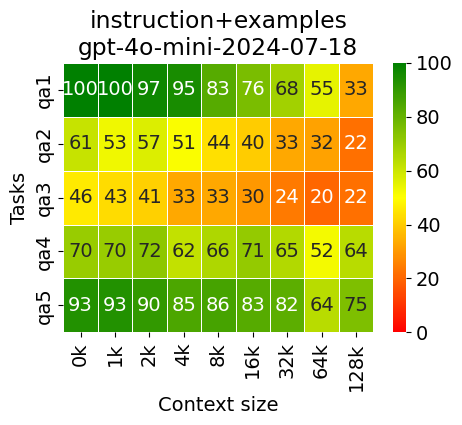

In [26]:
accuracy = np.ones((len(tasks), len(lengths))) * -1
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        prompt_cfg = {
            'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
            'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
            'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
            'template': DEFAULT_TEMPLATE,
            'chat_template': use_chat_template,
        }
        prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
        prompt_name = '_'.join(prompt_name)

        fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'],
                                                             question=row['question'], task_labels=TASK_LABELS[task]),
                                                             axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)
# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)
figsize=(5, 3.5)
fig, ax = plt.subplots(1, 1, figsize=figsize)  # Adjust the size as necessary

sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)

prompt_name = '+'.join([k for k in ['instruction', 'examples'] if prompt_cfg[k] != ''])
ax.set_title(f'{prompt_name}\n{model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')
plt.show()
